In [22]:
%load_ext autoreload
%autoreload 2
import os
import sys
from pathlib import Path
import joblib

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
from src.Bayesian import *
from src.Bayesian.problems.config import config_fgt
from src.Bayesian.problems import *
from src.Bayesian.utils.optimizer import Optimizer, ConstantDict
from src.Bayesian.utils.model_evaluation import ModelEval

In [26]:
# Example module config
module_config = {
    "perception": (BasePerception, {}),
    "memory": (BaseMemory, {
        "personal_memory_range": {
            "gamma": (0.05, 1.0),
            "w0": (0.075, 0.15)
        },
        "param_resolution": 20
    }),
    "cluster": (PartitionCluster, {
        "transition_spec": [("random_4", "top_posterior"),
                            ("opp_random_4", "random")]
    })
}
optimizer = Optimizer(module_config, n_jobs=100)

# 导入数据
processed_path = Path(project_root) / 'data' / 'processed'
optimizer.prepare_data(processed_path / 'Task2_processed.csv')

In [28]:
iSub = 1
training_results = optimizer.optimize_params_with_subs_parallel(
    config_fgt, [iSub], 16, 1, 10, stop_at=0.5)

Computing error for params: 100%|██████████| 10/10 [00:00<00:00, 7977.00it/s]


In [5]:
results[1].keys()

dict_keys(['condition', 'best_params', 'best_error', 'best_step_results', 'raw_step_results', 'grid_errors', 'sample_errors'])

In [6]:
len(results[1]["best_step_results"])

64

In [33]:
iSub = 1
test_results = optimizer.on_policy_with_subs_parallel(training_results,
    config_fgt, [iSub], 16, 10)

Computing error for params: 100%|██████████| 10/10 [00:00<00:00, 10818.43it/s]


In [34]:
full_trajectory = training_results[iSub]["best_step_results"] + test_results[iSub]["best_step_results"]



In [ ]:
results[1].keys()

dict_keys(['condition', 'best_params', 'best_error', 'best_step_results', 'raw_step_results', 'grid_errors', 'sample_errors'])

In [26]:
results[1]["best_step_results"][20]

{'best_k': 0,
 'best_beta': 30.0,
 'best_params': {'k': 0, 'beta': 30.0, 'gamma': 0.95, 'w0': 0.075},
 'best_log_likelihood': -1.7168557646434033,
 'best_norm_posterior': 0.8546131996233622,
 'hypo_details': {0: {'beta_opt': 30.0,
   'll_max': -1.7168557646434033,
   'post_max': 0.8546131996233622,
   'is_best': True},
  16: {'beta_opt': 5.526577691246585,
   'll_max': -6.22179783710506,
   'post_max': 0.009447091307811229,
   'is_best': False},
  5: {'beta_opt': 14.202042732031986,
   'll_max': -4.649134147336296,
   'post_max': 0.04552996068180893,
   'is_best': False},
  6: {'beta_opt': 10.706681882684682,
   'll_max': -3.9802001544072665,
   'post_max': 0.08888154949208035,
   'is_best': False},
  12: {'beta_opt': 4.5742192940646795,
   'll_max': -8.294531555018551,
   'post_max': 0.001188834217860767,
   'is_best': False},
  14: {'beta_opt': 0.001,
   'll_max': -9.548184739327292,
   'post_max': 0.00033936467707627253,
   'is_best': False}},
 'perception_stimuli': array([0.8436493

In [ ]:
# save results
result_path = Path(project_root) / 'results' / 'Model_results'
os.makedirs(result_path, exist_ok=True)

optimizer.save_results(results, 'M7_PMH_sub1', result_path)

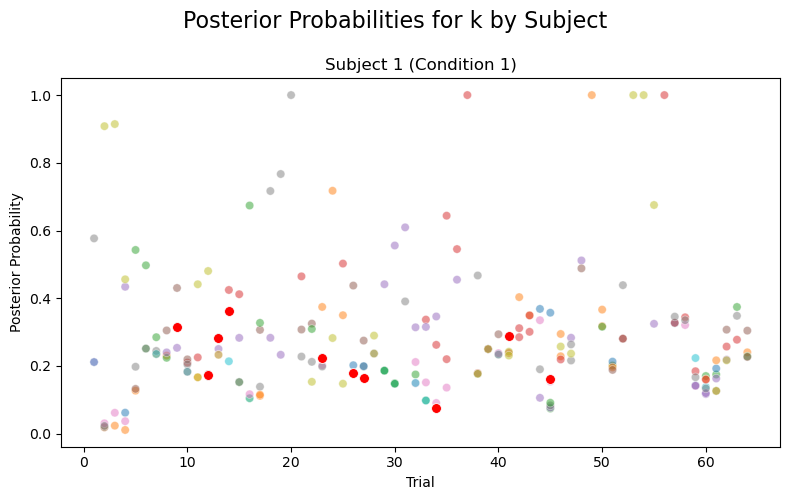

In [39]:
model_eval = ModelEval()
model_eval.plot_posterior_probabilities(test_results, [iSub])

In [6]:
optimizer.set_results(results)
prediction = optimizer.predict_with_subs_parallel(
    config_fgt, [iSub])

Predicting tasks: 100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 1314.42it/s]

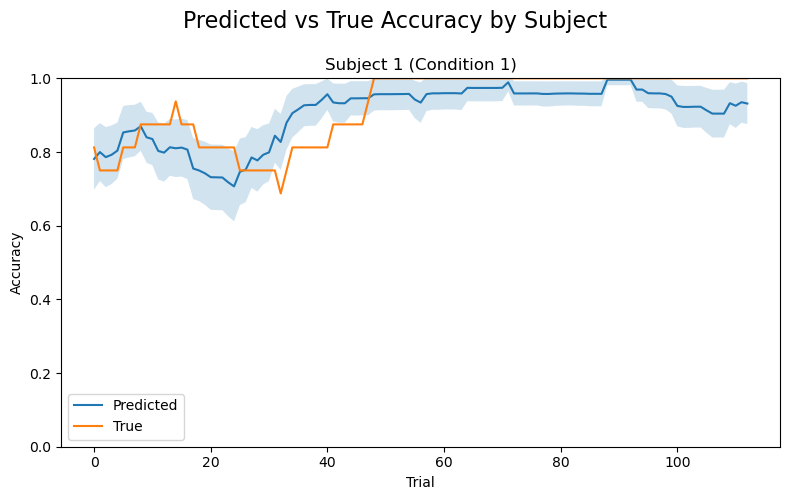

In [7]:
model_eval.plot_accuracy_comparison(prediction, [iSub])

In [8]:
from src.Bayesian.utils.oral_process import Oral_to_coordinate
oral_to_coordinate = Oral_to_coordinate()

learning_data = pd.read_csv(processed_path / 'Task2_processed.csv')
oral_hypo_hits = oral_to_coordinate.get_oral_hypo_hits(learning_data)

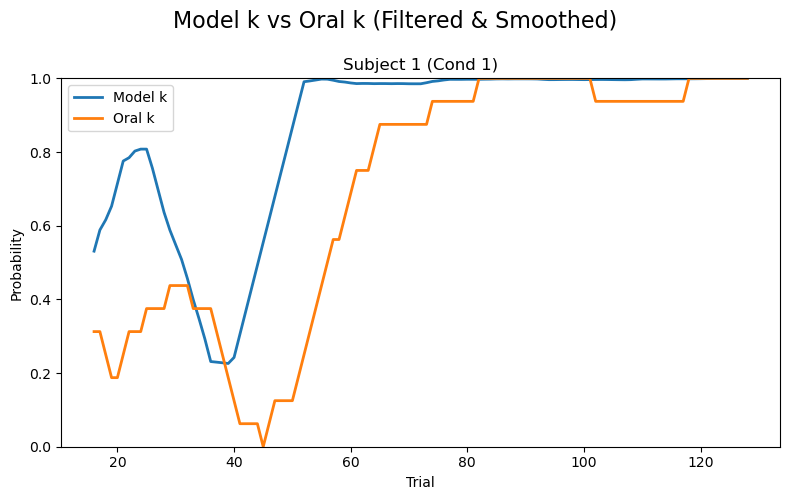

In [9]:
model_eval.plot_k_oral_comparison(results, oral_hypo_hits, [iSub])

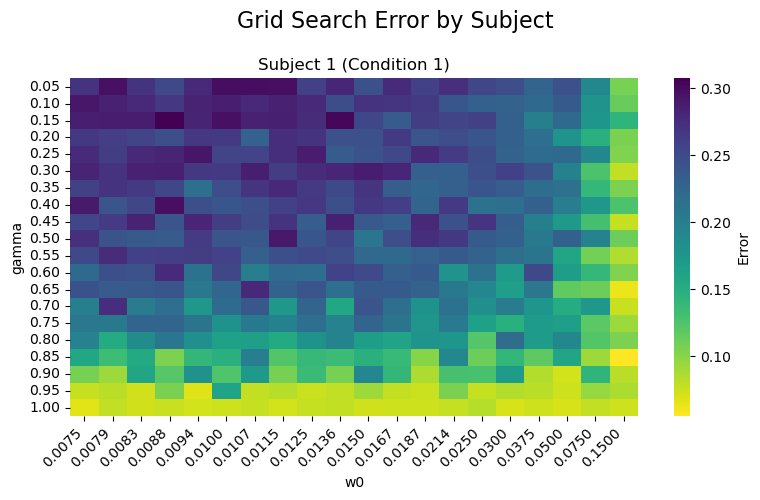

In [12]:
model_eval.plot_error_grids(results, fname=['gamma','w0'])

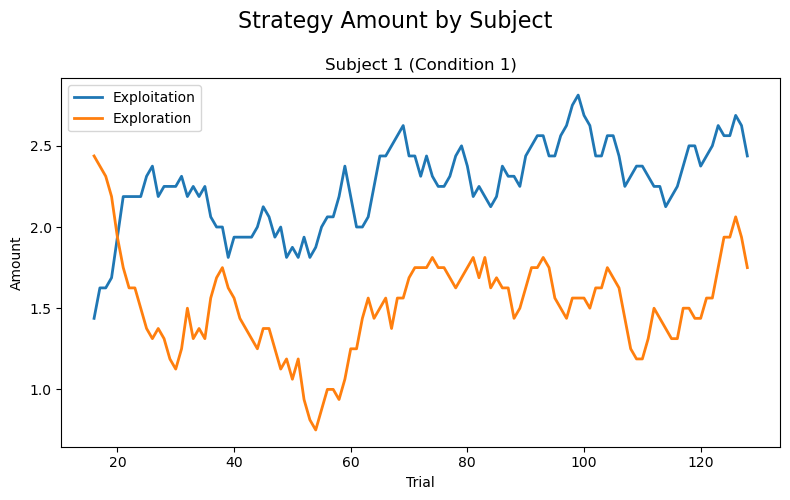

In [13]:
model_eval.plot_cluster_amount(results, 16, [iSub])